In [36]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Case: Análise de risco de crédito.

## Introdução

A fraude de risco de crédito acontece quando alguém tenta obter crédito de forma desonesta ou enganosa. Isso pode ocorrer quando alguém mente sobre sua situação financeira ou forja documentos para conseguir um empréstimo ou financiamento. Em resumo, é quando alguém tenta enganar um credor para obter dinheiro ou bens sem a intenção real de pagar de volta.

Para conter essa situação muitas instituições tendem a classificar seus clientes de forma a identificar quais tem melhores condições de retorno do crédito e os que não têm.

## Proposta de resolução:
Efetuei Três propostas de resolução para fins de comparação de otimização.

## Preparação Geral, Seleção de características.

In [2]:
import pandas as pd
# Carregando os dados
loc = r'/content/dataframe.csv'

# Criando o primeiro DF baseado nos clientes.
df = pd.read_csv(loc)

# Habilitando a visualização de todas as colunas.
pd.set_option('display.max_columns', 35 )
df.info()
print('=======================================================================')
print(df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8159 entries, 0 to 8158
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   label            8159 non-null   int64  
 1   id               8159 non-null   int64  
 2   fea_1            8159 non-null   int64  
 3   fea_2            7176 non-null   float64
 4   fea_3            8159 non-null   int64  
 5   fea_4            8159 non-null   float64
 6   fea_5            8159 non-null   int64  
 7   fea_6            8159 non-null   int64  
 8   fea_7            8159 non-null   int64  
 9   fea_8            8159 non-null   int64  
 10  fea_9            8159 non-null   int64  
 11  fea_10           8159 non-null   int64  
 12  fea_11           8159 non-null   float64
 13  OVD_t1           8159 non-null   int64  
 14  OVD_t2           8159 non-null   int64  
 15  OVD_t3           8159 non-null   int64  
 16  OVD_sum          8159 non-null   int64  
 17  pay_normal    

In [ ]:
# Eliminando colunas desnecessárias.
columns_to_drop = ['update_date', 'report_date', 'id']
df = df.drop(columns=columns_to_drop)
df.head(3)

,label,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,prod_code,prod_limit,new_balance,highest_balance
0,1,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974,0,0,0,0,9,10,60500.0,6657.6,18934.0
1,1,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974,0,0,0,0,18,10,NaN,153792.0,149387.0
2,1,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974,0,0,0,0,1,5,NaN,0.0,150500.0


In [ ]:
# Divissão dos dados em treino, teste e validação.

from sklearn.model_selection import train_test_split

def dividir_dados(df):
    # Divisão dos dados em treino, validação e teste
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns=['label']),  # features
        df['label'],  # target
        test_size=0.2,  # proporção de teste (20%)
        random_state=91  # para reproduzibilidade
    )

X_train, X_test, y_train, y_test= dividir_dados(df)

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Inicializar o classificador RandomForest
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=42)

# Treinar o modelo com os dados resampleados
rf_classifier.fit(X_train_imputed, y_train)

# Obter a importância das features
feature_importances = rf_classifier.feature_importances_

# Definir o limiar
limiar = 0.045

# Filtrar as features com importância acima do limiar
features_selecionadas = [i for i, importance in enumerate(feature_importances) if importance > limiar]

# Mostrar as features selecionadas
print("Features selecionadas:")
for feature_index in features_selecionadas:
    print(f'Feature {feature_index+1}: {feature_importances[feature_index]}')

print('==========================================')

# Obter os nomes das features de X_resampled
nomes_features = X_train.columns

# Mostrar os nomes das features selecionadas
print("Features selecionadas:")
for feature_index in features_selecionadas:
    print(f'Feature {nomes_features[feature_index]}: {feature_importances[feature_index]}')


Features selecionadas:
Feature 2: 0.1086265101040505
Feature 4: 0.1723022844970205
Feature 8: 0.09770849627106797
Feature 10: 0.1122798328129213
Feature 11: 0.10300254313879613
Feature 16: 0.04777754752299613
Feature 19: 0.05465836145035123
Feature 20: 0.06685657800210526
Features selecionadas:
Feature fea_2: 0.1086265101040505
Feature fea_4: 0.1723022844970205
Feature fea_8: 0.09770849627106797
Feature fea_10: 0.1122798328129213
Feature fea_11: 0.10300254313879613
Feature pay_normal: 0.04777754752299613
Feature new_balance: 0.05465836145035123
Feature highest_balance: 0.06685657800210526


## Primeira Abordagem - Randomforest + Undersampling

In [11]:
# Pipeline da primeira abordagem.

from sklearn.model_selection import train_test_split

def dividir_dados(df):
    # Divisão dos dados em treino, validação e teste
    X_train_validation, X_test, y_train_validation, y_test = train_test_split(
        df.drop(columns=['label']),  # features
        df['label'],  # target
        test_size=0.2,  # proporção de teste (20%)
        random_state=91,  # para reproduzibilidade
        stratify=df['label']
    )

    # Divisão dos dados de treino e validação
    X_train, X_validation, y_train, y_validation = train_test_split(
        X_train_validation,  # features
        y_train_validation,  # target
        test_size=0.15,  # proporção de validação (15% do conjunto de treino)
        random_state=91,  # para reproduzibilidade
        stratify=y_train_validation
    )

    return X_train, X_validation, X_test, y_train, y_validation, y_test

# Criando um novo dataframe apenas com as novas features.
df_2 = pd.read_csv(loc)

# Criando a lista de colunas a ser removida.
drop_col = ['id','fea_1','fea_3','fea_5','fea_6','fea_7','fea_9','OVD_t1','OVD_t2','OVD_t3','OVD_sum',
            'prod_code','prod_limit','update_date','report_date']

# Removendo do dataframe
df_2 = df_2.drop(drop_col, axis =1)

# Dividindo os dados.
X_train, X_validation, X_test, y_train, y_validation, y_test= dividir_dados(df_2)

In [12]:
from sklearn.utils import resample

# Identificar exemplos da classe majoritária (supondo que seja a classe com label 0)
train_majoritarios = X_train[y_train == 0]
teste_majoritarios = X_test[y_test == 0]
valida_majoritarios = X_validation[y_validation == 0]
# Identificar exemplos da classe minoritária (supondo que seja a classe com label 1)
train_minoritarios = X_train[y_train == 1]
teste_minoritarios = X_test[y_test == 1]
valida_minoritarios = X_validation[y_validation == 1]
# Realizar undersampling da classe majoritária
train_majoritarios_undersampled = resample(train_majoritarios, replace=False, n_samples=len(train_minoritarios), random_state=42)
teste_majoritarios_undersampled = resample(teste_majoritarios, replace=False, n_samples=len(teste_minoritarios), random_state=42)
valida_majoritarios_undersampled = resample(valida_majoritarios, replace=False, n_samples=len(valida_minoritarios), random_state=42)
# Combinar exemplos da classe minoritária com exemplos da classe majoritária undersampled
X_train_balanced = np.concatenate([train_majoritarios_undersampled, train_minoritarios])
y_train_balanced = np.concatenate([np.zeros(len(train_majoritarios_undersampled)), np.ones(len(train_minoritarios))])

X_test_balanced = np.concatenate([teste_majoritarios_undersampled, teste_minoritarios])
y_test_balanced = np.concatenate([np.zeros(len(teste_majoritarios_undersampled)), np.ones(len(teste_minoritarios))])

X_valida_balanced = np.concatenate([valida_majoritarios_undersampled, valida_minoritarios])
y_valida_balanced = np.concatenate([np.zeros(len(valida_majoritarios_undersampled)), np.ones(len(valida_minoritarios))])


In [14]:
from sklearn.impute import SimpleImputer

# Criando um imputer com a estratégia da média apenas para as colunas numéricas
imputer = SimpleImputer(strategy='median')

# Aplicando o imputer
X_train_imputed = X_train.copy()  # Copiando o DataFrame original
X_train_imputed = imputer.fit_transform(X_train_balanced)
X_test_imputed = imputer.fit_transform(X_test_balanced)
X_valida_imputed = imputer.fit_transform(X_valida_balanced)

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

# Definir o espaço de busca para os hiperparâmetros
param_grid = {
    'n_estimators': [100, 200, 300, 1000, 5000,10000],
    'max_depth': [None, 10, 20],
    # Outros hiperparâmetros a serem ajustados
}

# Criar um modelo de Random Forest
rf_grid = RandomForestClassifier(random_state= 42)

# Criar uma instância do GridSearchCV
grid_search = GridSearchCV(rf_grid, param_grid, cv= 5, scoring='accuracy')

# Treinar o GridSearchCV com os dados selecionados
grid_search.fit(X_train_imputed, y_train_balanced)

# Mostrar os melhores parâmetros encontrados
print("Melhores parâmetros:", grid_search.best_params_)

# Avaliar o modelo final no conjunto de validação
accuracy_test = grid_search.score(X_valida_imputed, y_valida_balanced)
print("Acurácia no conjunto de validação:", accuracy_test)

Melhores parâmetros: {'max_depth': 20, 'n_estimators': 100}
Acurácia no conjunto de validação: 0.9181818181818182


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Definir o modelo com os melhores hiperparâmetros encontrados
modelo_final = RandomForestClassifier(max_depth= 20, n_estimators=100, random_state=42)

# Treinar o modelo nos dados de treino
modelo_final.fit(X_train_imputed, y_train_balanced)

# Prever os rótulos para os dados de teste
y_pred_teste = modelo_final.predict(X_test_imputed)
y_probs_teste = modelo_final.predict_proba(X_test_imputed)[:, 1]

# Calcular métricas de desempenho nos dados de teste
accuracy_teste = accuracy_score(y_test_balanced, y_pred_teste)
precision_teste = precision_score(y_test_balanced, y_pred_teste)
recall_teste = recall_score(y_test_balanced, y_pred_teste)
f1_teste = f1_score(y_test_balanced, y_pred_teste)
roc_auc_teste = roc_auc_score(y_test_balanced, y_probs_teste)

# Calcular métricas de desempenho nos dados de validação
y_pred_validacao = modelo_final.predict(X_valida_imputed)
y_probs_validacao = modelo_final.predict_proba(X_valida_imputed)[:, 1]

accuracy_validacao = accuracy_score(y_valida_balanced, y_pred_validacao)
precision_validacao = precision_score(y_valida_balanced, y_pred_validacao)
recall_validacao = recall_score(y_valida_balanced, y_pred_validacao)
f1_validacao = f1_score(y_valida_balanced, y_pred_validacao)
roc_auc_validacao = roc_auc_score(y_valida_balanced, y_probs_validacao)

# Exibir métricas de desempenho nos dados de teste e validação
print("Métricas de Desempenho nos Dados de Teste:")
print("Accuracy:", accuracy_teste.round(3))
print("Precision:", precision_teste.round(3))
print("Recall:", recall_teste.round(3))
print("F1-score:", f1_teste.round(3))
print("ROC-AUC:", roc_auc_teste.round(3))

print("\nMétricas de Desempenho nos Dados de Validação:")
print("Accuracy:", accuracy_validacao.round(3))
print("Precision:", precision_validacao.round(3))
print("Recall:", recall_validacao.round(3))
print("F1-score:", f1_validacao.round(3))
print("ROC-AUC:", roc_auc_validacao.round(3))


Métricas de Desempenho nos Dados de Teste:
Accuracy: 0.904
Precision: 0.896
Recall: 0.913
F1-score: 0.905
ROC-AUC: 0.973

Métricas de Desempenho nos Dados de Validação:
Accuracy: 0.918
Precision: 0.916
Recall: 0.921
F1-score: 0.918
ROC-AUC: 0.973


## Segunda Abordagem -- Randomforest + OverSampling.

In [20]:
# Pipeline da segunda abordagem.

from sklearn.model_selection import train_test_split

def dividir_dados(df):
    # Divisão dos dados em treino, validação e teste
    X_train_validation, X_test, y_train_validation, y_test = train_test_split(
        df.drop(columns=['label']),  # features
        df['label'],  # target
        test_size=0.2,  # proporção de teste (20%)
        random_state=91,  # para reproduzibilidade
        stratify=df['label']
    )

    # Divisão dos dados de treino e validação
    X_train, X_validation, y_train, y_validation = train_test_split(
        X_train_validation,  # features
        y_train_validation,  # target
        test_size=0.15,  # proporção de validação (15% do conjunto de treino)
        random_state=91,  # para reproduzibilidade
        stratify=y_train_validation
    )

    return X_train, X_validation, X_test, y_train, y_validation, y_test

# Criando um novo dataframe apenas com as novas features.
df_3 = pd.read_csv(loc)

# Criando a lista de colunas a ser removida.
drop_col = ['id','fea_1','fea_3','fea_5','fea_6','fea_7','fea_9','OVD_t1','OVD_t2','OVD_t3','OVD_sum',
            'prod_code','prod_limit','update_date','report_date']

# Removendo do dataframe
df_3 = df_3.drop(drop_col, axis =1)

# Dividindo os dados.
X_train, X_validation, X_test, y_train, y_validation, y_test= dividir_dados(df_3)

In [22]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.fit_transform(X_test)
X_validation_imputed = imputer.fit_transform(X_validation)

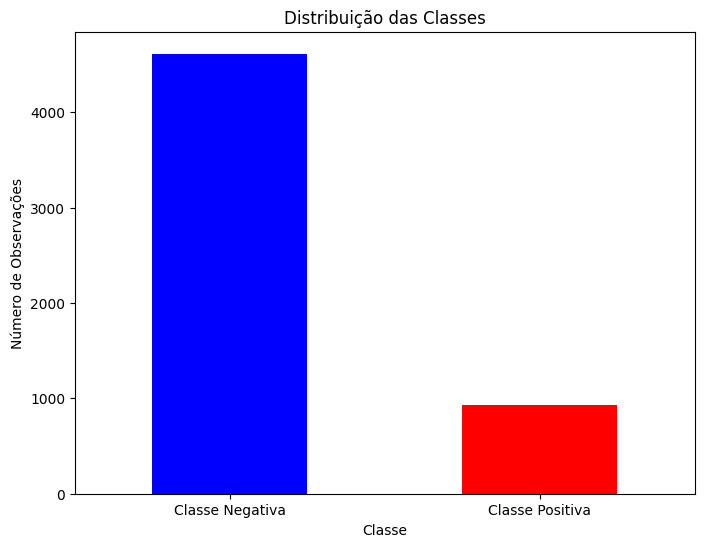

In [26]:
# Contagem de observações por classe
class_counts = y_train.value_counts()

# Visualização da distribuição das classes
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['blue', 'red'])
plt.title('Distribuição das Classes')
plt.xlabel('Classe')
plt.ylabel('Número de Observações')
plt.xticks(ticks=[0, 1], labels=['Classe Negativa', 'Classe Positiva'], rotation=0)
plt.show()

In [23]:
from imblearn.over_sampling import SMOTE

# Criar uma instância do SMOTE
smote = SMOTE()

# Aplicar o SMOTE aos seus dados
X_resampled, y_resampled = smote.fit_resample(X_train_imputed, y_train)

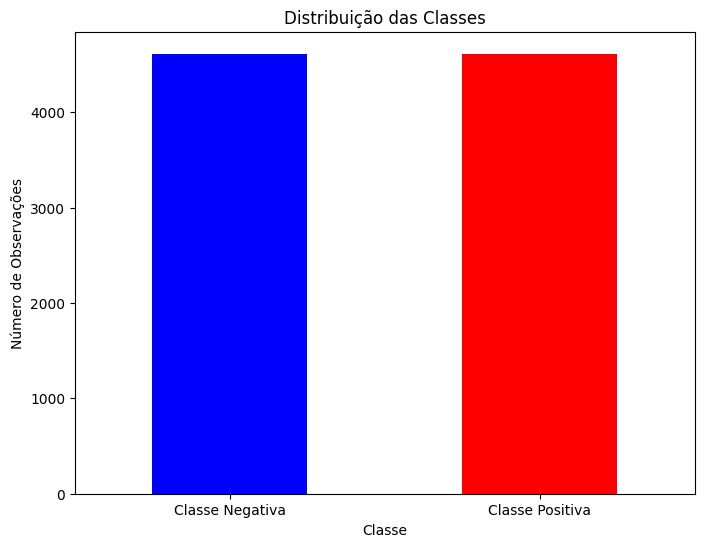

In [24]:
# Contagem de observações por classe
class_counts = y_resampled.value_counts()

# Visualização da distribuição das classes
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['blue', 'red'])
plt.title('Distribuição das Classes')
plt.xlabel('Classe')
plt.ylabel('Número de Observações')
plt.xticks(ticks=[0, 1], labels=['Classe Negativa', 'Classe Positiva'], rotation=0)
plt.show()

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

# Definir o espaço de busca para os hiperparâmetros
param_grid = {
    'n_estimators': [100, 200, 300, 1000],
    'max_depth': [None, 10, 20],
    # Outros hiperparâmetros a serem ajustados
}

# Criar um modelo de Random Forest
rf_grid = RandomForestClassifier(random_state= 42)

# Criar uma instância do GridSearchCV
grid_search = GridSearchCV(rf_grid, param_grid, cv=5, scoring='accuracy')

# Treinar o GridSearchCV com os dados selecionados
grid_search.fit(X_resampled, y_resampled)

# Mostrar os melhores parâmetros encontrados
print("Melhores parâmetros:", grid_search.best_params_)

# Avaliar o modelo final no conjunto de validação
accuracy_test = grid_search.score(X_validation_imputed, y_validation)
print("Acurácia no conjunto de validação:", accuracy_test)


Melhores parâmetros: {'max_depth': None, 'n_estimators': 1000}
Acurácia no conjunto de validação: 0.960204081632653


In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Definir o modelo com os melhores hiperparâmetros encontrados
modelo_final_2 = RandomForestClassifier(max_depth= None, n_estimators=1000, random_state=42)

# Treinar o modelo nos dados de treino
modelo_final_2.fit(X_resampled, y_resampled)

# Prever os rótulos para os dados de teste
y_pred_teste = modelo_final.predict(X_test_imputed)
y_probs_teste = modelo_final.predict_proba(X_test_imputed)[:, 1]

# Calcular métricas de desempenho nos dados de teste
accuracy_teste = accuracy_score(y_test, y_pred_teste)
precision_teste = precision_score(y_test, y_pred_teste)
recall_teste = recall_score(y_test, y_pred_teste)
f1_teste = f1_score(y_test, y_pred_teste)
roc_auc_teste = roc_auc_score(y_test, y_probs_teste)

# Calcular métricas de desempenho nos dados de validação
y_pred_validacao = modelo_final.predict(X_validation_imputed)
y_probs_validacao = modelo_final.predict_proba(X_validation_imputed)[:, 1]

accuracy_validacao = accuracy_score(y_validation, y_pred_validacao)
precision_validacao = precision_score(y_validation, y_pred_validacao)
recall_validacao = recall_score(y_validation, y_pred_validacao)
f1_validacao = f1_score(y_validation, y_pred_validacao)
roc_auc_validacao = roc_auc_score(y_validation, y_probs_validacao)

# Exibir métricas de desempenho nos dados de teste e validação
print("Métricas de Desempenho nos Dados de Teste:")
print("Accuracy:", accuracy_teste.round(3))
print("Precision:", precision_teste.round(3))
print("Recall:", recall_teste.round(3))
print("F1-score:", f1_teste.round(3))
print("ROC-AUC:", roc_auc_teste.round(3))

print("\nMétricas de Desempenho nos Dados de Validação:")
print("Accuracy:", accuracy_validacao.round(3))
print("Precision:", precision_validacao.round(3))
print("Recall:", recall_validacao.round(3))
print("F1-score:", f1_validacao.round(3))
print("ROC-AUC:", roc_auc_validacao.round(3))


Métricas de Desempenho nos Dados de Teste:
Accuracy: 0.965
Precision: 0.94
Recall: 0.847
F1-score: 0.891
ROC-AUC: 0.99

Métricas de Desempenho nos Dados de Validação:
Accuracy: 0.96
Precision: 0.914
Recall: 0.842
F1-score: 0.877
ROC-AUC: 0.991
